In [329]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
import nltk
from nltk import  punkt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import csv
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

# Preprocessing

In [330]:
np.random.seed(500)

In [331]:
transactions = pd.read_csv("newtransactions.csv",encoding='latin-1')
missing_value = pd.DataFrame(transactions.isna().sum().sort_values(ascending=False),columns=['No.records'])
missing_value['percentage']=(transactions.isna().sum()/len(transactions))*100

In [332]:
transactions['sms'].dropna(inplace=True)

In [333]:
transactions['sms'] = [entry.lower() for entry in transactions['sms']]

In [334]:
transactions.head()

,ï»¿bankname,type,sms
0,AlAhli,Withdrawl,pos purchase (apple pay)\namount 990 sar\nmada...
1,Sabb,Other,"dear customer, please update your personal inf..."
2,Gulf International bank,Withdrawl,"atm withdrawal \namount: sar 2,500.00 \ncard:*..."
3,Gulf International bank,Withdrawl,pos purchase\namount: sar 85.42\nat:aldrees 40...
4,Gulf International bank,Other,notification: online banking service\nstatus: ...


In [335]:
print(transactions.shape)
print(transactions.size)
print(transactions['sms'])

(204, 3)
612
0      pos purchase (apple pay)\namount 990 sar\nmada...
1      dear customer, please update your personal inf...
2      atm withdrawal \namount: sar 2,500.00 \ncard:*...
3      pos purchase\namount: sar 85.42\nat:aldrees 40...
4      notification: online banking service\nstatus: ...
                             ...                        
199    credit transfer internal\namount: 1,400 sar\nt...
200    dear customer,\nto complete the internet purch...
201    online purchase\namount: 48.85 sar\nmada card:...
202    debit transfer internal\namount: 200 sar\nto b...
203    mada atheer pos purchase\namount: 129 sar\nmad...
Name: sms, Length: 204, dtype: object


In [336]:
#this method deletes arabic word in an english text
def remove_arabic(msg):
    arr_msg = msg.split(' ');
    

    regexPattern = "^[A-Za-z0-9]+";
    

    english_arr_msg = [ i for i in arr_msg if re.search(regexPattern,i) and i != '']


    space = " "
    return space.join(english_arr_msg)


In [337]:
#remove_arabic
transactions['sms'] = [remove_arabic(entry) for entry in transactions['sms']]

#test message before tokenize it & all arabic text removed 
print(transactions['sms'][10])


outgoing fund transfer approved
from: sar 76.29
beneficiary name: iban: bank: 05-08-2022 21:46:04
reference id: 2240434872
transaction id: sd6775406


In [338]:
#tokenizedWords = np.empty(204, dtype = str)
tokenizer = RegexpTokenizer("[\w+|\$[\d\.]+|\S+]+")

#for i in range(204):
   # for x in transactions['sms']:
     #       token =  tokenizer.tokenize(x)
        
transactions['sms']= [tokenizer.tokenize(entry) for entry in transactions['sms']]
           
       

In [339]:
#Test row number 4 with tozentation 
#PoS Purchase (Apple Pay)
#Amount 990 SAR
#Mada card *1868
#Account 745*104
#From STC Pay
#on 29/03/2022 at 12:50

#Do we care about date as whole? Do we care as time as a whole? to differnciate between time-date and amount :)?

print(transactions['sms'][10])

['outgoing', 'fund', 'transfer', 'approved', 'from', 'sar', '76.29', 'beneficiary', 'name', 'iban', 'bank', '05', '08', '2022', '21', '46', '04', 'reference', 'id', '2240434872', 'transaction', 'id', 'sd6775406']


In [340]:
transactions['sms']

0      [pos, purchase, pay, amount, 990, sar, mada, c...
1      [dear, customer, please, update, your, persona...
2      [atm, withdrawal, sar, 2, 500.00, riyadh, cent...
3      [pos, purchase, amount, sar, 85.42, at, aldree...
4      [notification, online, banking, service, statu...
                             ...                        
199    [credit, transfer, internal, amount, 1, 400, s...
200    [dear, customer, to, complete, the, internet, ...
201    [online, purchase, amount, 48.85, sar, mada, c...
202    [debit, transfer, internal, amount, 200, sar, ...
203    [mada, atheer, pos, purchase, amount, 129, sar...
Name: sms, Length: 204, dtype: object

In [341]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


for index,entry in enumerate(transactions['sms']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'sms_final'
    transactions.loc[index,'sms_final'] = str(Final_words)
       
    

[nltk_data] Downloading package wordnet to /Users/hailah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/hailah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hailah/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hailah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [342]:
transactions.tail()

,ï»¿bankname,type,sms,sms_final
199,Alinma,Deposit,"[credit, transfer, internal, amount, 1, 400, s...","['credit', 'transfer', 'internal', 'amount', '..."
200,Alinma,Other,"[dear, customer, to, complete, the, internet, ...","['dear', 'customer', 'complete', 'internet', '..."
201,Alinma,Withdrawl,"[online, purchase, amount, 48.85, sar, mada, c...","['online', 'purchase', 'amount', 'sar', 'mada'..."
202,Alinma,Withdrawl,"[debit, transfer, internal, amount, 200, sar, ...","['debit', 'transfer', 'internal', 'amount', 's..."
203,Alinma,Withdrawl,"[mada, atheer, pos, purchase, amount, 129, sar...","['mada', 'atheer', 'pos', 'purchase', 'amount'..."


<Figure size 432x288 with 0 Axes>

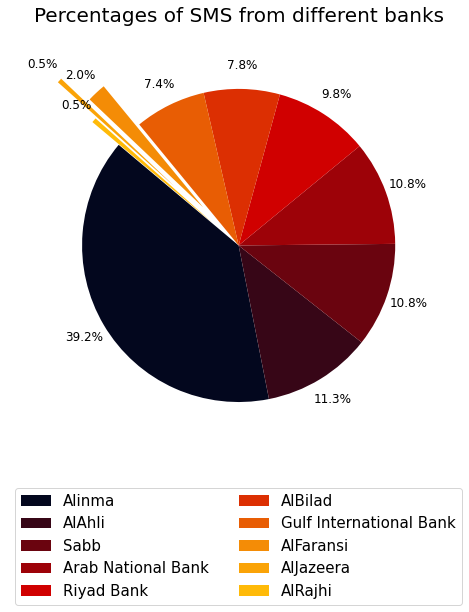

In [343]:
#Save CSV after modicifactions to data analysis
#transactions.to_csv('transactions.csv', index=False)


bankSet = ['Alinma','AlAhli', 'Sabb', 'Arab National Bank', 'Riyad Bank', 'AlBilad', 'Gulf International Bank', 'AlFaransi',
          'AlJazeera', 'AlRajhi']

explode = [0, 0, 0, 0, 0, 0, 0, 0.3, 0.5, 0.2]
fig = plt.figure()
plt.figure(figsize=(8,8))
colors =  ['#03071E', '#370617', '#6A040F', '#9D0208', '#D00000', '#DC2F02', '#E85D04', '#F48C06', '#FAA307', '#FFBA08']

transactions.iloc[:,0].value_counts().plot.pie(labels = None ,startangle=140, textprops =textprops, autopct='%.1f%%',
                                        pctdistance=1.15, rotatelabels=180, colors = colors, radius=0.9, explode=explode)


#plt.legend( loc="best", labels=country) 
 
plt.title("Percentages of SMS from different banks", fontsize=20)
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.04), ncol=2, labels=bankSet, fontsize=15)
plt.xlabel(" ")
plt.ylabel(" ")


plt.show()



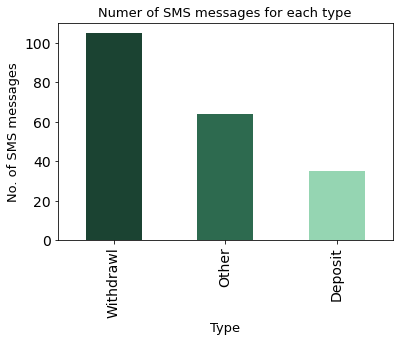

In [344]:
transactions["type"].value_counts().plot(kind="bar", color=["#1B4332","#2D6A4F","#95D5B2"], fontsize = 14)
plt.title("Numer of SMS messages for each type", fontsize=13)

plt.xlabel("Type",fontsize=13)
plt.ylabel("No. of SMS messages", fontsize=13)


plt.show()

# SVM & Naieve Bayes

In [345]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(transactions['sms_final'],transactions['type'],test_size=0.3)


In [346]:
#0 => deposit , 1=>others , 2=> withdrawls
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [347]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(transactions['sms_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [348]:
print(Tfidf_vect.vocabulary_)

{'pos': 240, 'purchase': 243, 'pay': 227, 'amount': 38, 'sar': 270, 'mada': 188, 'card': 76, 'stc': 287, 'dear': 97, 'customer': 92, 'please': 236, 'update': 313, 'personal': 231, 'information': 162, 'within': 325, 'day': 96, 'avoid': 59, 'account': 2, 'kindly': 174, 'need': 211, 'visit': 320, 'sabb': 265, 'atm': 55, 'withdrawal': 324, 'riyadh': 261, 'cent': 77, 'sa': 263, 'date': 95, 'aldrees': 21, 'type': 309, 'apple': 43, 'notification': 215, 'online': 220, 'banking': 63, 'service': 277, 'status': 286, 'block': 70, 'incorrect': 161, 'password': 226, 'attempt': 56, 'action': 3, 'use': 314, 'forget': 132, 'step': 288, 'meem': 196, 'app': 42, 'unblock': 310, 'call': 75, 'contact': 87, 'center': 78, 'location': 181, 'due': 107, 'schedule': 275, 'system': 296, 'telemoney': 299, 'available': 58, 'anb': 39, 'net': 212, 'mobile': 199, 'saturday': 273, 'appreciate': 45, 'number': 217, 'international': 167, 'portugal': 239, 'fee': 127, 'log': 182, 'fransiplus': 134, 'another': 40, 'outgo': 22

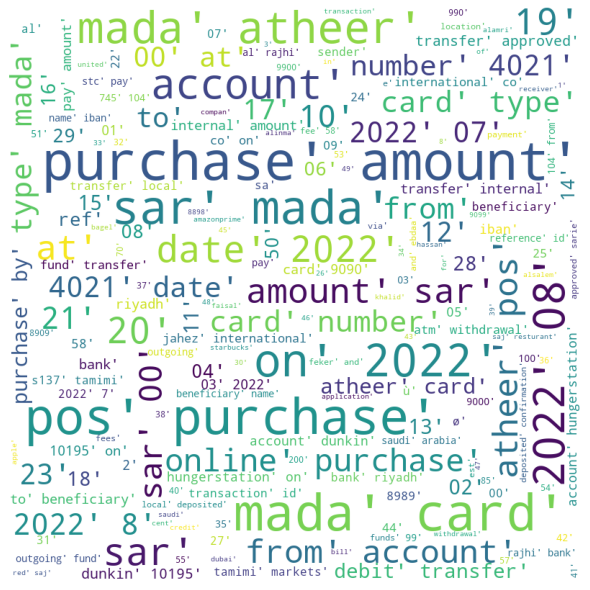

In [349]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
comment_words = ''
stopwords = set(STOPWORDS)

sms = transactions[transactions['type'] == "Withdrawl"]['sms']

# iterate through the csv file
for val in sms:
    val = str(val)


    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()


    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


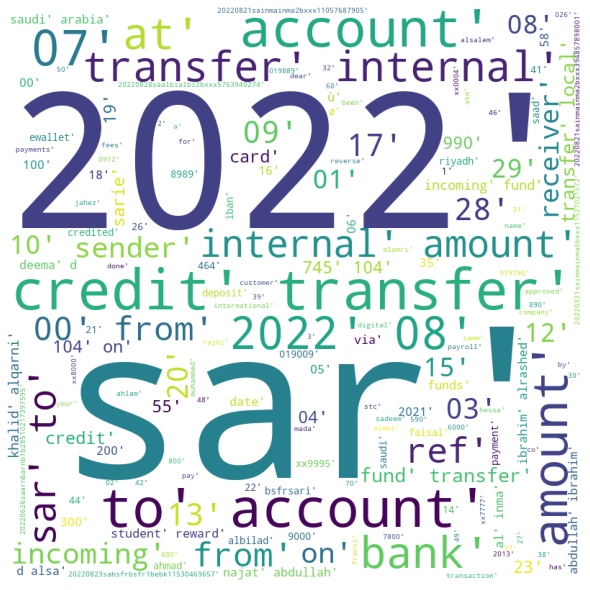

In [350]:
comment_words = ''
stopwords = set(STOPWORDS)

sms = transactions[transactions['type'] == "Deposit"]['sms']

# iterate through the csv file
for val in sms:
    val = str(val)

    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


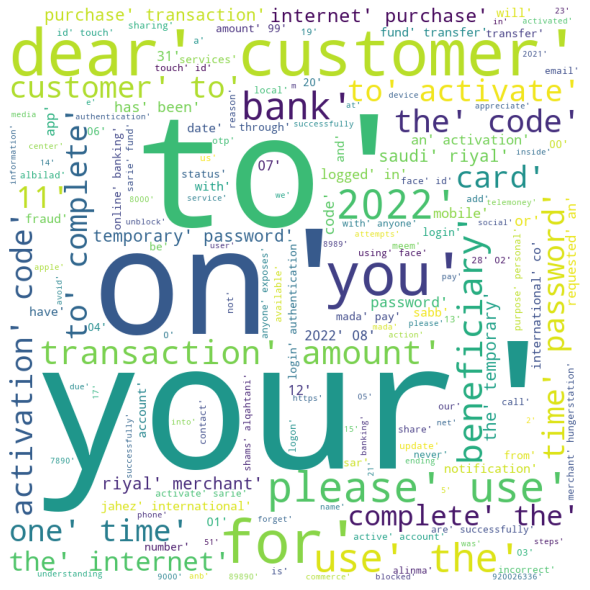

In [351]:
comment_words = ''
stopwords = set(STOPWORDS)

sms = transactions[transactions['type'] == "Other"]['sms']

# iterate through the csv file
for val in sms:
    val = str(val)


    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()


    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [352]:
#1: Row number of ‘Train_X_Tfidf’,
#2: Unique Integer number of each word in the first row,
#3: Score calculated by TF-IDF Vectorizer
print(Train_X_Tfidf)

  (0, 313)	0.3036342655079457
  (0, 296)	0.33654012986726
  (0, 277)	0.2918896541601225
  (0, 230)	0.3626589837952964
  (0, 200)	0.3626589837952964
  (0, 107)	0.33654012986726
  (0, 97)	0.20533026627377896
  (0, 92)	0.2081937163468285
  (0, 62)	0.18207486241879214
  (0, 58)	0.3180085080881589
  (0, 45)	0.33654012986726
  (1, 270)	0.17762846197873788
  (1, 243)	0.2464136165628446
  (1, 240)	0.3100260361311755
  (1, 188)	0.5157754904085502
  (1, 108)	0.5169818023099193
  (1, 76)	0.25450363286014194
  (1, 54)	0.34197539595560345
  (1, 38)	0.20404626583556906
  (1, 2)	0.23444322635351195
  (2, 305)	0.31242455786646617
  (2, 270)	0.13353263752101538
  (2, 171)	0.36328039152540104
  (2, 167)	0.33734812063010217
  (2, 82)	0.4772174169354131
  :	:
  (140, 270)	0.1554089064673384
  (140, 250)	0.19005080220907997
  (140, 247)	0.25489113427715754
  (140, 245)	0.24621987641029947
  (140, 180)	0.1963074477491879
  (140, 154)	0.2033481036139354
  (140, 149)	0.31669008619495354
  (140, 138)	0.1769095

In [353]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  95.16129032258065


In [354]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  88.70967741935483


# Evaluation metrics

#### SVM

TN - True Negative 9
FP - False Positive 0
FN - False Negative 0
TP - True Positive 21
Accuracy Rate: 0.4838709677419355
Misclassification Rate: 0.0


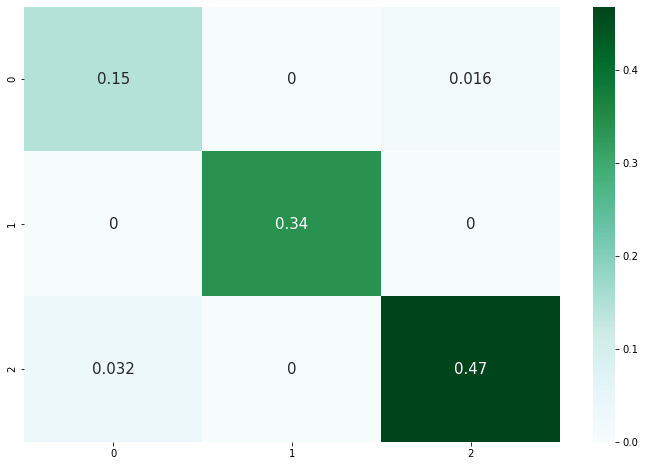

In [355]:
# confusion matrix Train_X, Test_X, Train_Y, Test_Y
cf_matrix = confusion_matrix(Test_Y.tolist(), predictions_SVM.tolist())
plt.subplots(figsize=(12,8))
_= sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = "BuGn", annot = True, annot_kws = {'size':15})
print('TN - True Negative {}'.format(cf_matrix[0,0]))
print('FP - False Positive {}'.format(cf_matrix[0,1]))
print('FN - False Negative {}'.format(cf_matrix[1,0]))
print('TP - True Positive {}'.format(cf_matrix[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cf_matrix[0,0],cf_matrix[1,1]]),np.sum(cf_matrix))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cf_matrix[0,1],cf_matrix[1,0]]),np.sum(cf_matrix))))

In [356]:
print(classification_report(Test_Y, predictions_SVM))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       1.00      1.00      1.00        21
           2       0.97      0.94      0.95        31

    accuracy                           0.95        62
   macro avg       0.93      0.95      0.94        62
weighted avg       0.95      0.95      0.95        62



#### NB

TN - True Negative 7
FP - False Positive 0
FN - False Negative 0
TP - True Positive 18
Accuracy Rate: 0.4032258064516129
Misclassification Rate: 0.0


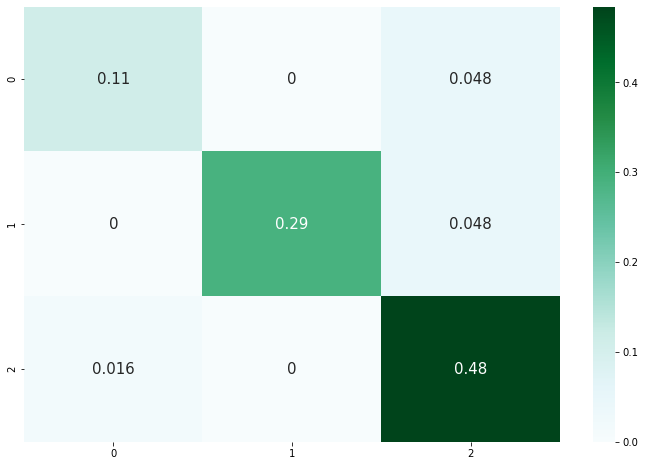

In [357]:
# confusion matrix Train_X, Test_X, Train_Y, Test_Y
cf_matrix = confusion_matrix(Test_Y.tolist(), predictions_NB.tolist())
plt.subplots(figsize=(12,8))
_= sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = "BuGn", annot = True, annot_kws = {'size':15})
print('TN - True Negative {}'.format(cf_matrix[0,0]))
print('FP - False Positive {}'.format(cf_matrix[0,1]))
print('FN - False Negative {}'.format(cf_matrix[1,0]))
print('TP - True Positive {}'.format(cf_matrix[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cf_matrix[0,0],cf_matrix[1,1]]),np.sum(cf_matrix))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cf_matrix[0,1],cf_matrix[1,0]]),np.sum(cf_matrix))))

In [358]:
print(classification_report(Test_Y, predictions_NB))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       1.00      0.86      0.92        21
           2       0.83      0.97      0.90        31

    accuracy                           0.89        62
   macro avg       0.90      0.84      0.87        62
weighted avg       0.90      0.89      0.89        62

